## American Call Option 

American options can be exercised anytime before expiration, with exercise time $\tau$ chosen to maximize option value based on time $t$ and stock price $S(t)$.

For American **calls** on non-dividend stocks, early exercise is never optimal. Early exercise sacrifices two key advantages: 

- Interest earned on delayed strike payment 
- Downside protection from the right to walk away

**Mathematical Justifcation:** Consider two portfolios at time $t$:

- **Portfolio E:** One American call $c$ plus $Ke^{-r(T-t)}$ in cash

$$c(\tau) + Ke^{-r(T-\tau)}$$

- **Portfolio F:** One share of stock $S$

At time $\tau < T$: Portfolio E satisfies $c(\tau) + Ke^{-r(T-\tau)} \geq S(\tau)$ by the no-arbitrage bound $c(\tau) \geq S(\tau) - Ke^{-r(T-\tau)}$.

At expiration $T$: Portfolio E is worth $\max(S(T) - K, 0) + K = \max(S(T), K) \geq S(T)$ = Portfolio F.

**Key insight:**

$$S(\tau) - Ke^{-r(T-\tau)} > S(\tau) - K \quad \text{when } r > 0 \text{ and } \tau < T$$

The option value exceeds immediate exercise payoff by at least the interest savings $K(1 - e^{-r(T-\tau)})$ plus downside protection value. Therefore, selling the option dominates early exercise, proving $c_{\text{American}} = c_{\text{European}}$ for non-dividend stocks.

## American Puts: The Early Exercise Premium

American put value decomposes as:

$$p_{\text{American}}(S,t) = p_{\text{European}}(S,t) + \text{Early Exercise Premium}$$

**The Trade-off:** Exercising a put early means receiving strike price $K$ immediately to earn interest, creating value when interest earned on $K$ exceeds remaining time value. This premium depends on the carry term $(r - q)$:

* High $r$ → favors early exercise (more interest earned)
* High $q$ → favors holding (stock drops on ex-dividend)

**Optimal Exercise Boundary:** Critical stock price $S^*(t)$ exists where immediate exercise is optimal:

$$p(S^*,t) = K - S^* \quad \text{and} \quad \frac{\partial p}{\partial S}\bigg|_{S=S^*} = -1$$

The boundary increases toward $K$ as expiration approaches, balancing interest earned against lost optionality. This early exercise premium is what makes $p_{\text{American}} > p_{\text{European}}$ for puts.

## Why Numerical Methods Are Needed

The free boundary problem for American options has no closed-form solution due to:

1. **Coupled nonlinearity:** The boundary $S^*(t)$ is coupled with option values in the continuation region
2. **Path-dependent optimization:** At each $(S,t)$, must compare exercise value $K - S$ vs. continuation value
3. **Time-varying boundary:** $S^*(t)$ changes continuously with time to maturity

**Numerical Solutions:**

* **Binomial trees:** Discretize time and stock price, work backwards checking at each node:
$$V(S,t) = \max\left(K - S, \, e^{-r\Delta t}[pV_u + (1-p)V_d]\right)$$

* **Finite differences:** Discretize the Black-Scholes PDE and apply the constraint $V(S,t) \geq K - S$ at each grid point

* **Monte Carlo with regression:** Estimate continuation values via regression, compare to immediate exercise payoff

**Analytical Approximations (BAW, log-linear):** Impose a functional form on either the premium or boundary, trading exactness for speed. These achieve 0.1-1% accuracy for most practical cases while avoiding computational cost.

### Binomial Tree Implementation

**Backward Induction Process**

The binomial tree prices American options by working backwards from expiration. At each node, we compare immediate exercise versus continuation.

**Tree Parameters:**

At each time step $\Delta t = T/N$, the stock can move up or down:

$$u = e^{\sigma\sqrt{\Delta t}}, \quad d = \frac{1}{u}$$

The risk-neutral probability of an up move is:

$$p = \frac{e^{(r-q)\Delta t} - d}{u - d}$$

**Step 1: Terminal Payoffs (t = T)**

At maturity, the option value equals the intrinsic value:

$$V(S, T) = \max(K - S, 0)$$

**Step 2: Backward Through Time**

For each earlier time step $t < T$ and stock price $S$:

**Continuation Value** (expected discounted future value):
$$C(S,t) = e^{-r\Delta t}[p \cdot V_{\text{up}} + (1-p) \cdot V_{\text{down}}]$$

**Exercise Value** (immediate payoff):
$$E(S,t) = \max(K - S, 0)$$

**American Option Value** (take maximum):
$$V(S,t) = \max(E(S,t), C(S,t))$$

If $E(S,t) \geq C(S,t)$: Exercise immediately  
If $E(S,t) < C(S,t)$: Hold and continue

This process repeats backwards until we reach $t=0$, giving us $V(S_0, 0)$ = the American put price.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def binomial_american_put(S0, K, T, r, q, sigma, N):
    """
    Vectorized American put using binomial tree
    """
    # Parameters
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)
    disc = np.exp(-r * dt)
    
    # Stock price tree at maturity (all terminal nodes)
    i = np.arange(N + 1)
    stock_prices = S0 * (u ** (N - i)) * (d ** i)
    
    # Option values at maturity
    option_values = np.maximum(K - stock_prices, 0)
    
    # Store boundary
    exercise_boundary = np.zeros(N + 1)
    exercise_boundary[N] = K
    
    # Backward induction
    for step in range(N - 1, -1, -1):
        # Stock prices at this time step
        i = np.arange(step + 1)
        stock_prices = S0 * (u ** (step - i)) * (d ** i)
        
        # Continuation value (vectorized)
        option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])
        
        # Immediate exercise value
        exercise_values = np.maximum(K - stock_prices, 0)
        
        # American option: take maximum
        option_values = np.maximum(option_values, exercise_values)
        
        # Find exercise boundary (first stock price where we exercise)
        exercise_mask = option_values >= exercise_values - 1e-10
        if np.any(exercise_mask):
            exercise_boundary[step] = stock_prices[exercise_mask][0]
        else:
            exercise_boundary[step] = 0
    
    return option_values[0], exercise_boundary

def binomial_european_put(S0, K, T, r, q, sigma, N):
    """
    Vectorized European put using binomial tree
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)
    disc = np.exp(-r * dt)
    
    # Terminal stock prices
    i = np.arange(N + 1)
    stock_prices = S0 * (u ** (N - i)) * (d ** i)
    
    # Terminal option values
    option_values = np.maximum(K - stock_prices, 0)
    
    # Backward induction (vectorized, no early exercise)
    for step in range(N):
        option_values = disc * (p * option_values[:-1] + (1 - p) * option_values[1:])
    
    return option_values[0]

In [18]:
# Parameters
S0 = 100
K = 100
T = 1.0
r = 0.05
q = 0.03
sigma = 0.20
N = 100

### Price Path

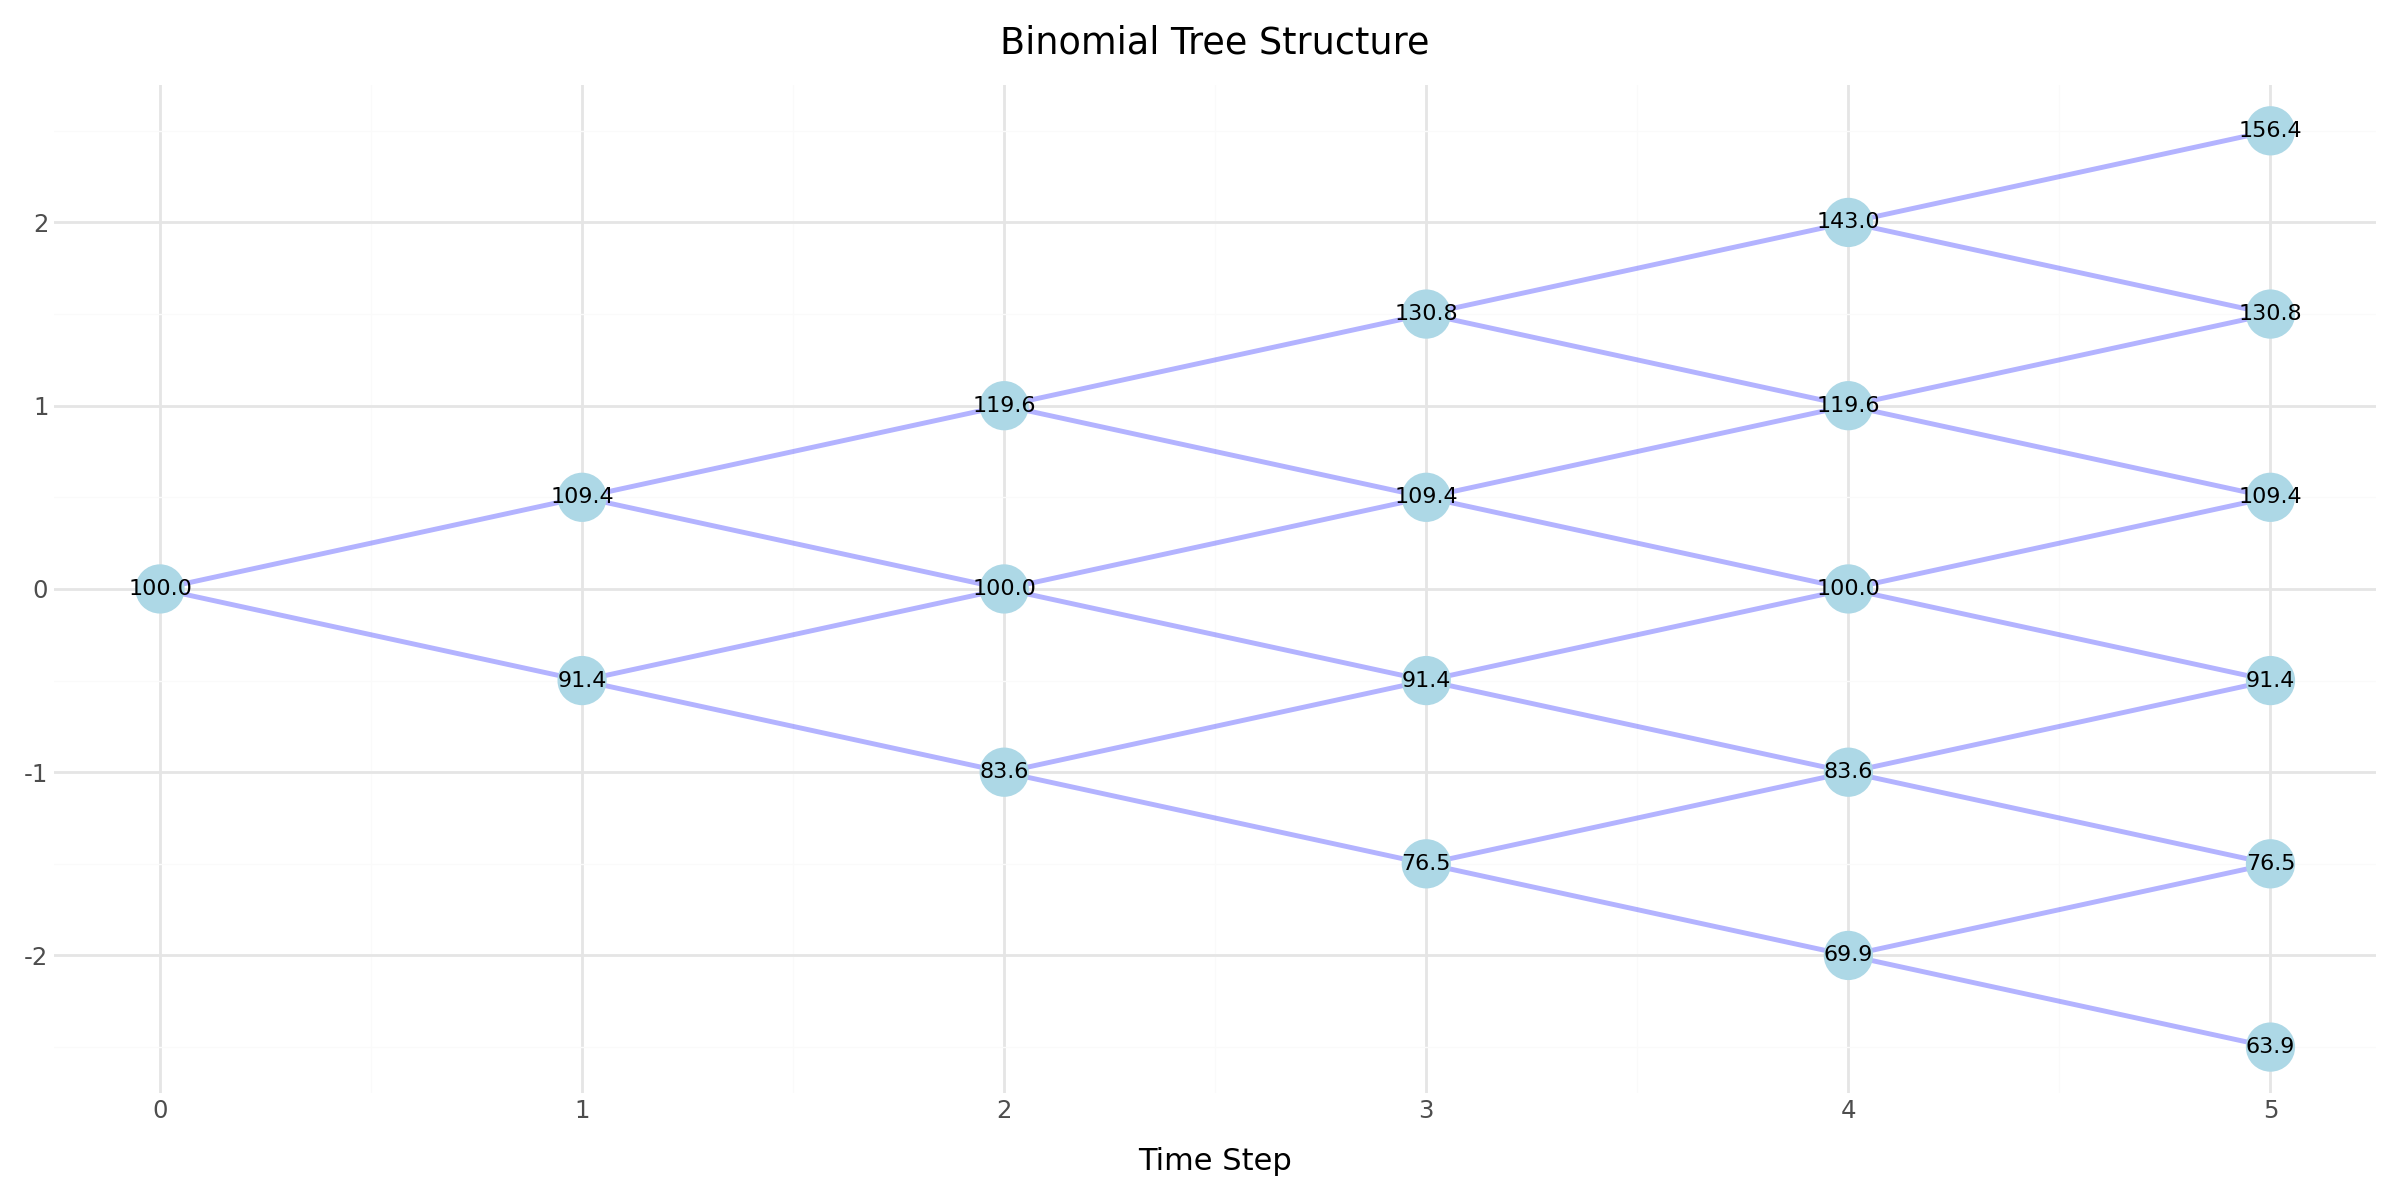

In [14]:
import numpy as np
import pandas as pd
from plotnine import *

# Build tree
dt = T / N
u = np.exp(sigma * np.sqrt(dt))
d = 1 / u

# Create dataframe for nodes
nodes = []
edges = []

for i in range(N+1):
    for j in range(i+1):
        x, y = i, -j + i/2
        price = S0 * (u**(i-j)) * (d**j)
        nodes.append({'x': x, 'y': y, 'price': price})
        
        # Add edges
        if i < N:
            # Up edge
            edges.append({'x': x, 'y': y, 'xend': x+1, 'yend': -j + (i+1)/2})
            # Down edge
            edges.append({'x': x, 'y': y, 'xend': x+1, 'yend': -(j+1) + (i+1)/2})

df_nodes = pd.DataFrame(nodes)
df_edges = pd.DataFrame(edges)

# Plot
(ggplot() +
 geom_segment(df_edges, aes(x='x', y='y', xend='xend', yend='yend'), 
              alpha=0.3, color='blue', size=1) +
 geom_point(df_nodes, aes(x='x', y='y'), 
            color='lightblue', size=8, stroke=1) +
 geom_text(df_nodes, aes(x='x', y='y', label='price'), 
           format_string='{:.1f}', size=8) +
 labs(title='Binomial Tree Structure', x='Time Step', y='') +
 theme_minimal() +
 theme(figure_size=(12, 6))
)

In [19]:
# Price options
american_price, boundary = binomial_american_put(S0, K, T, r, q, sigma, N)
european_price = binomial_european_put(S0, K, T, r, q, sigma, N)

print(f"American Put Price: ${american_price:.4f}")
print(f"European Put Price: ${european_price:.4f}")
print(f"Early Exercise Premium: ${american_price - european_price:.4f}")

American Put Price: $6.9621
European Put Price: $6.7117
Early Exercise Premium: $0.2503


### LSMC (Least Squares Monte Carlo) Implementation


LSMC prices American options by simulating stock price paths forward, then working backwards to determine optimal exercise decisions using regression.

**Step 1: Simulate Stock Price Paths**

Generate $M$ paths using Geometric Brownian Motion:

$$S_{t+\Delta t} = S_t \exp\left[\left(r - q - \frac{\sigma^2}{2}\right)\Delta t + \sigma\sqrt{\Delta t}Z\right]$$

where $Z \sim N(0,1)$ is a standard normal random variable.

**Step 2: Initialize Terminal Payoffs**

At maturity $T$, payoffs are known:

$$\text{Payoff}_i(T) = \max(K - S_i(T), 0) \quad \text{for path } i = 1, \ldots, M$$

**Step 3: Backward Induction with Regression**

For each time step $t = T-\Delta t, T-2\Delta t, \ldots, \Delta t$:

**3a) Identify in-the-money paths:**
$$\text{ITM} = \{i : K - S_i(t) > 0\}$$

**3b) Regression to estimate continuation value:**

For ITM paths, estimate continuation value using polynomial regression:

$$C(S) = \beta_0 + \beta_1 S + \beta_2 S^2 + \beta_3 S^3$$

Fit by least squares:
- **X:** Current stock prices $S_i(t)$ for ITM paths
- **Y:** Discounted future payoffs $e^{-r\Delta t} \cdot \text{Payoff}_i(t+\Delta t)$

**3c) Exercise decision:**

For each ITM path $i$:

$$\text{Exercise value: } E_i(t) = K - S_i(t)$$
$$\text{Continuation value: } C_i(t) = \beta_0 + \beta_1 S_i(t) + \beta_2 S_i(t)^2 + \beta_3 S_i(t)^3$$

**Decision rule:**
$$\text{Payoff}_i(t) = \begin{cases}
E_i(t) & \text{if } E_i(t) > C_i(t) \text{ (exercise)} \\
e^{-r\Delta t} \cdot \text{Payoff}_i(t+\Delta t) & \text{otherwise (hold)}
\end{cases}$$

**Step 4: Calculate Option Value**

Average the discounted payoffs across all paths:

$$V_{\text{American}} = e^{-r\Delta t} \cdot \frac{1}{M}\sum_{i=1}^M \text{Payoff}_i(\Delta t)$$

**Key Innovation:** Regression estimates the continuation value without needing to discretize the state space, allowing LSMC to scale to high-dimensional problems where tree methods fail.

In [20]:
def lsmc_american_put(S0, K, T, r, q, sigma, N_steps, N_paths):
    """
    Least Squares Monte Carlo for American Put
    
    Parameters:
    N_steps: number of time steps
    N_paths: number of simulated paths
    """
    dt = T / N_steps
    disc = np.exp(-r * dt)
    
    # Step 1: Simulate stock price paths (GBM)
    np.random.seed(42)
    Z = np.random.standard_normal((N_paths, N_steps))
    
    # Initialize paths
    paths = np.zeros((N_paths, N_steps + 1))
    paths[:, 0] = S0
    
    # Generate paths
    for t in range(1, N_steps + 1):
        paths[:, t] = paths[:, t-1] * np.exp((r - q - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z[:, t-1])
    
    # Step 2: Initialize payoff at maturity
    payoff = np.maximum(K - paths[:, -1], 0)
    
    # Step 3: Work backwards through time
    for t in range(N_steps - 1, 0, -1):
        # Current stock prices and exercise values
        S_t = paths[:, t]
        exercise_value = np.maximum(K - S_t, 0)
        
        # Find in-the-money paths
        itm = exercise_value > 0
        
        if np.sum(itm) > 0:
            # Regression: estimate continuation value for ITM paths
            X = S_t[itm]
            Y = payoff[itm] * disc  # discounted future payoff
            
            # Polynomial basis functions: 1, S, S^2, S^3
            X_poly = np.column_stack([np.ones_like(X), X, X**2, X**3])
            
            # Least squares regression
            coeffs = np.linalg.lstsq(X_poly, Y, rcond=None)[0]
            
            # Estimated continuation value
            continuation_value = X_poly @ coeffs
            
            # Exercise if immediate payoff > continuation value
            exercise = exercise_value[itm] > continuation_value
            
            # Update payoff: exercise now or keep future payoff
            payoff[itm] = np.where(exercise, exercise_value[itm], payoff[itm] * disc)
            payoff[~itm] = payoff[~itm] * disc
        else:
            # No ITM paths, just discount
            payoff = payoff * disc
    
    # Step 4: Discount to present value
    option_price = np.mean(payoff) * disc
    
    return option_price, paths

In [27]:
lsmc_price, paths = lsmc_american_put(S0, K, T, r, q, sigma, N_steps = 50, N_paths = 10000)
american_price, boundary = binomial_american_put(S0, K, T, r, q, sigma, N = 100)
european_price = binomial_european_put(S0, K, T, r, q, sigma, N = 100)

PRICING COMPARISON
Binomial American Put:  $6.9621
Binomial European Put:  $6.7117
LSMC American Put:      $6.9814

Early Exercise Premium: $0.2503
LSMC vs Binomial Diff:  $0.0194


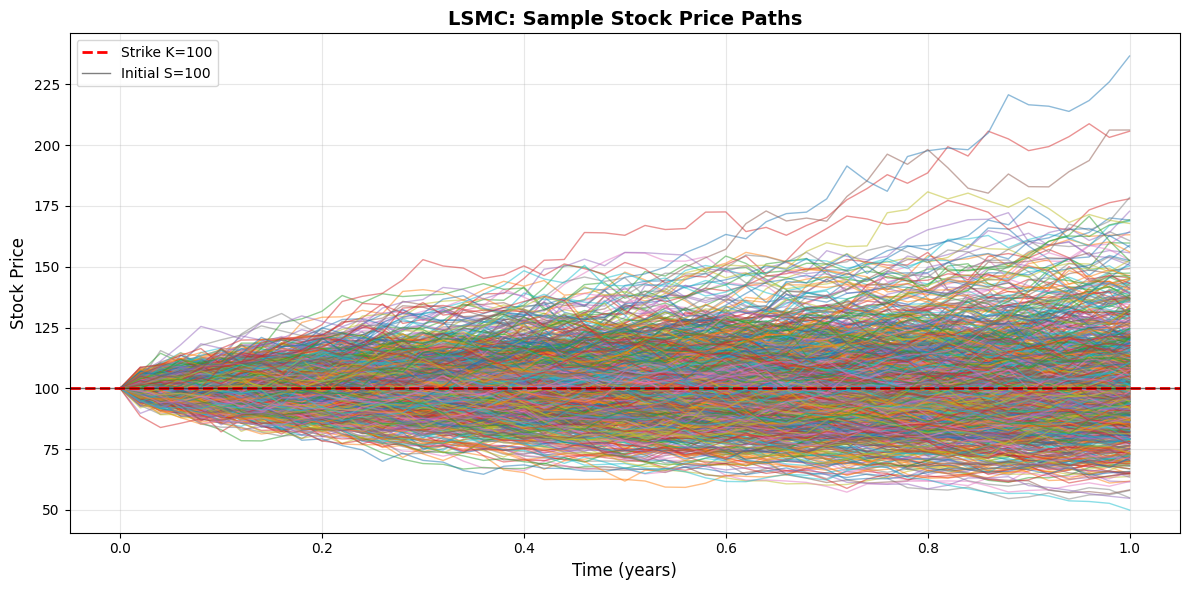

In [31]:
print("=" * 50)
print("PRICING COMPARISON")
print("=" * 50)
print(f"Binomial American Put:  ${american_price:.4f}")
print(f"Binomial European Put:  ${european_price:.4f}")
print(f"LSMC American Put:      ${lsmc_price:.4f}")
print(f"\nEarly Exercise Premium: ${american_price - european_price:.4f}")
print(f"LSMC vs Binomial Diff:  ${abs(lsmc_price - american_price):.4f}")
print("=" * 50)
N_steps = 50
# Plot sample paths
fig, ax = plt.subplots(figsize=(12, 6))
times = np.linspace(0, T, N_steps + 1)

# Plot 1000 sample paths
for i in range(1000):
    ax.plot(times, paths[i], alpha=0.5, linewidth=1)

ax.axhline(y=K, color='red', linestyle='--', linewidth=2, label=f'Strike K={K}')
ax.axhline(y=S0, color='black', linestyle='-', linewidth=1, alpha=0.5, label=f'Initial S={S0}')
ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Stock Price', fontsize=12)
ax.set_title('LSMC: Sample Stock Price Paths', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Results & Analysis**

The pricing comparison demonstrates the fundamental advantage of American options and validates our two implementation methods:

**Key Findings:**

American Put Price: **$6.96-6.98** (both methods)  
European Put Price: **$6.71**  
Early Exercise Premium: **$0.25** (3.6% of option value)

This early exercise premium exists because the American put holder can capture interest on the strike price when the option moves deep in-the-money, rather than waiting until expiration. With r=5% and q=3%, the positive carry (2%) makes early exercise optimal below a certain stock price boundary.

**Method Validation:**

The binomial tree (exact in the limit) and LSMC (Monte Carlo simulation with regression) agree within **$0.02 or 0.3%**. This close agreement validates both implementations and confirms the American option value.

For this single-stock problem, the binomial tree is actually more efficient. However, LSMC demonstrates can be scaled to real-world problems where binomial trees fail:

- **Binomial:** Optimal for 1-2 dimensions, provides exact early exercise boundary
- **LSMC:** Scales to multi-asset options (baskets, spreads) where trees become computationally intractable due to the curse of dimensionality

